In [187]:
#https://github.com/pomber/covid19
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import datetime

In [336]:
df = pd.read_csv('../data/brazil_corona19_data.csv')
df_estados = pd.read_csv('../data/brazilian_states.csv')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))

df.tail()

,id_estado,nome_estado,sigla_estado,id_regiao,nome_regiao,sigla_regiao
0,11,Rondônia,RO,1,Norte,N
1,12,Acre,AC,1,Norte,N
2,13,Amazonas,AM,1,Norte,N
3,14,Roraima,RR,1,Norte,N
4,15,Pará,PA,1,Norte,N
5,16,Amapá,AP,1,Norte,N
6,17,Tocantins,TO,1,Norte,N
7,21,Maranhão,MA,2,Nordeste,NE
8,22,Piauí,PI,2,Nordeste,NE
9,23,Ceará,CE,2,Nordeste,NE


In [337]:
df_brasil = pd.merge(df[df['date']==today], df_estados, how='inner', on=None, left_on='state', 
                 right_on='sigla_estado', left_index=False, right_index=False, sort=False)   

df_brasil = df_brasil[df_brasil['date']==today][['id_estado','avg7_perc_death','sigla_estado']]
df_brasil['id_estado'] = df_brasil['id_estado'].astype('str')# para fazer o key_on no folium

,id_estado,avg7_perc_death,sigla_estado
0,11,6.202857,RO
1,12,2.452857,AC
2,13,4.380000,AM
3,14,3.040000,RR
4,15,4.214286,PA
5,16,2.628571,AP
6,17,0.000000,TO
7,21,4.371429,MA
8,22,16.297143,PI
9,23,3.654286,CE


In [369]:
state_geo = json.load(open('../data/brasil-estados.json'))
for state in state_geo['features']: 
    latLong =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_estados.loc[df_estados['id_estado']==int(codarea),'lat'] = latLong[0]
    df_estados.loc[df_estados['id_estado']==int(codarea),'long'] = latLong[1]

df_estados.tail()

,id_estado,nome_estado,sigla_estado,id_regiao,nome_regiao,sigla_regiao,latLong,latlong,lat,long
22,43,Rio Grande do Sul,RS,4,Sul,S,-53.319974,NaN,-53.319974,-29.705809
23,50,Mato Grosso do Sul,MS,5,Centro-Oeste,CO,-54.845564,NaN,-54.845564,-20.327475
24,51,Mato Grosso,MT,5,Centro-Oeste,CO,-55.911975,NaN,-55.911975,-12.948919
25,52,Goiás,GO,5,Centro-Oeste,CO,-49.623608,NaN,-49.623608,-16.042109
26,53,Distrito Federal,DF,5,Centro-Oeste,CO,-47.797341,NaN,-47.797341,-15.780746


In [378]:
state_geo = json.load(open('../data/brasil-estados.json'))
m = folium.Map(location=[-15.75, -47.95], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_brasil,
    columns=['id_estado', 'avg7_perc_death'],
    key_on='feature.properties.codarea',
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='% letalidade (media movel 7 ultimos dias)'
).add_to(m)

folium.Marker(
    location=[-53.319974,-29.705809],
    radius=5000,
    popup='Laurelhurst Park',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/brazilMap.html')
m

----------------------------
### Brasil - Analysis and monitoring

#### Top 5 deadliest countries + Brazil

In [168]:
cols = ['state', 'date', 'day','case_day', 'cases', 'death_day', 'deaths', 'avg7_cases', 'avg7_deaths','avg7_perc_death', 'perc_death']
df_top_deaths = df[df['date']==today].sort_values('avg7_perc_death', ascending = False)

df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(10)
df_top_deaths

,state,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,PI,2020-12-04,24,3,44,0,7,3.000000,0.428571,16.297143,15.91
2,PB,2020-12-04,25,16,101,2,13,9.571429,1.285714,12.108571,12.87
3,SE,2020-12-04,29,2,44,0,4,1.714286,0.142857,10.444286,9.09
4,PE,2020-12-04,32,144,960,13,85,108.428571,9.142857,10.262857,8.85
5,SP,2020-12-04,47,336,8755,28,588,590.714286,44.714286,6.532857,6.72
6,AL,2020-12-04,36,0,48,0,3,2.857143,0.142857,6.484286,6.25
7,RO,2020-12-04,24,2,35,0,2,3.285714,0.142857,6.202857,5.71
8,RJ,2020-12-04,39,248,2855,15,170,208.714286,15.142857,5.568571,5.95
9,GO,2020-12-04,31,20,229,4,14,16.285714,1.571429,4.482857,6.11
10,AM,2020-12-04,29,156,1206,9,62,112.714286,6.857143,4.380000,5.14


#### Top 5 most transmissible countries + Brazil

In [169]:
df_top_cases = df[df['date']==today].sort_values('avg7_cases', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(10)
df_top_cases

,state,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,SP,2020-12-04,47,336,8755,28,588,590.714286,44.714286,6.532857,6.72
2,RJ,2020-12-04,39,248,2855,15,170,208.714286,15.142857,5.568571,5.95
3,CE,2020-12-04,27,94,1676,7,74,121.857143,6.857143,3.654286,4.42
4,AM,2020-12-04,29,156,1206,9,62,112.714286,6.857143,4.380000,5.14
5,PE,2020-12-04,32,144,960,13,85,108.428571,9.142857,10.262857,8.85
6,SC,2020-12-04,31,36,768,3,24,58.714286,2.000000,2.934286,3.12
7,MG,2020-12-04,36,56,806,3,20,44.000000,2.000000,2.205714,2.48
8,MA,2020-12-04,23,54,398,3,24,43.142857,3.142857,4.371429,6.03
9,PR,2020-12-04,32,62,738,4,30,42.857143,3.000000,3.421429,4.07
10,BA,2020-12-04,38,38,673,0,21,38.857143,1.714286,2.992857,3.12


#### Brazilian states to be analised

#### Cases and deaths 

In [379]:
#inform the countries you want to analise
monitoredStates = df_top_deaths['state'].head(10).to_numpy()
monitoredStates

array(['PI', 'PB', 'SE', 'PE', 'SP', 'AL', 'RO', 'RJ', 'GO', 'AM'],
      dtype=object)

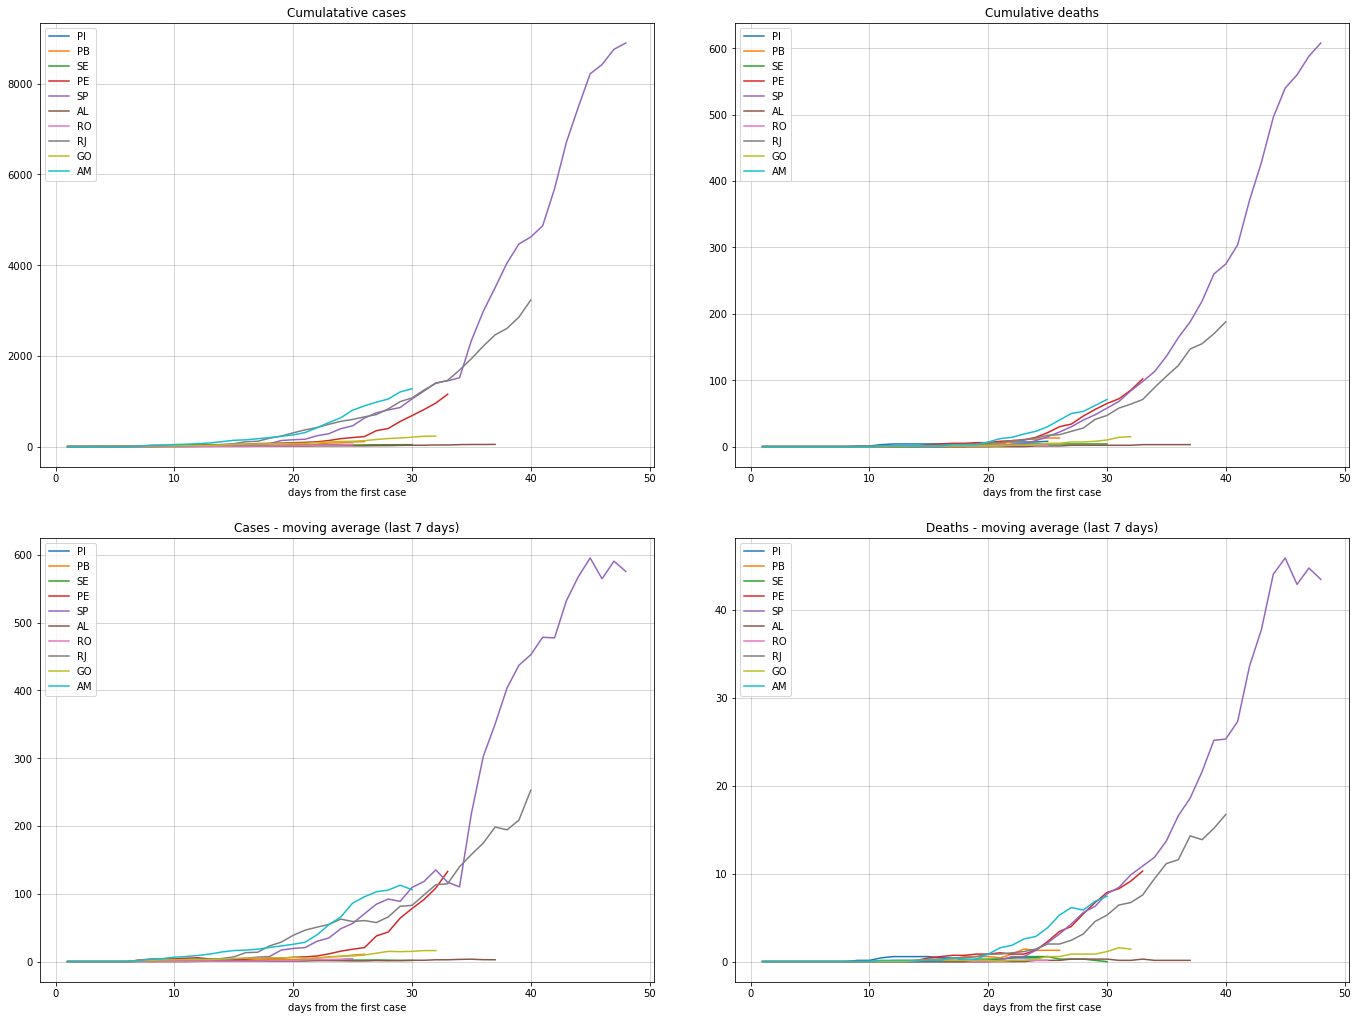

In [380]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Cumulative deaths")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cases - moving average (last 7 days)")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Deaths - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    ax1.plot(df[df['state'] == state].day, df[df['state'] == state].cases, label = state)
    ax2.plot(df[df['state'] == state].day, df[df['state'] == state].deaths, label = state)
    ax3.plot(df[df['state'] == state].day, df[df['state'] == state].avg7_cases, label = state)
    ax4.plot(df[df['state'] == state].day, df[df['state'] == state].avg7_deaths, label = state)
#     ax1.plot(df[df['country'] == country].day, df[df['country'] == country].cases, label = country)
#     ax2.plot(df[df['country'] == country].day, df[df['country'] == country].deaths, label = country)
#     ax3.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_cases, label = country)
#     ax4.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_deaths, label = country)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/brazilian_states_cases_deaths.png')

#### Active cases, world overview, % recoveries and lethality

NameError: name 'monitoredCountries' is not defined

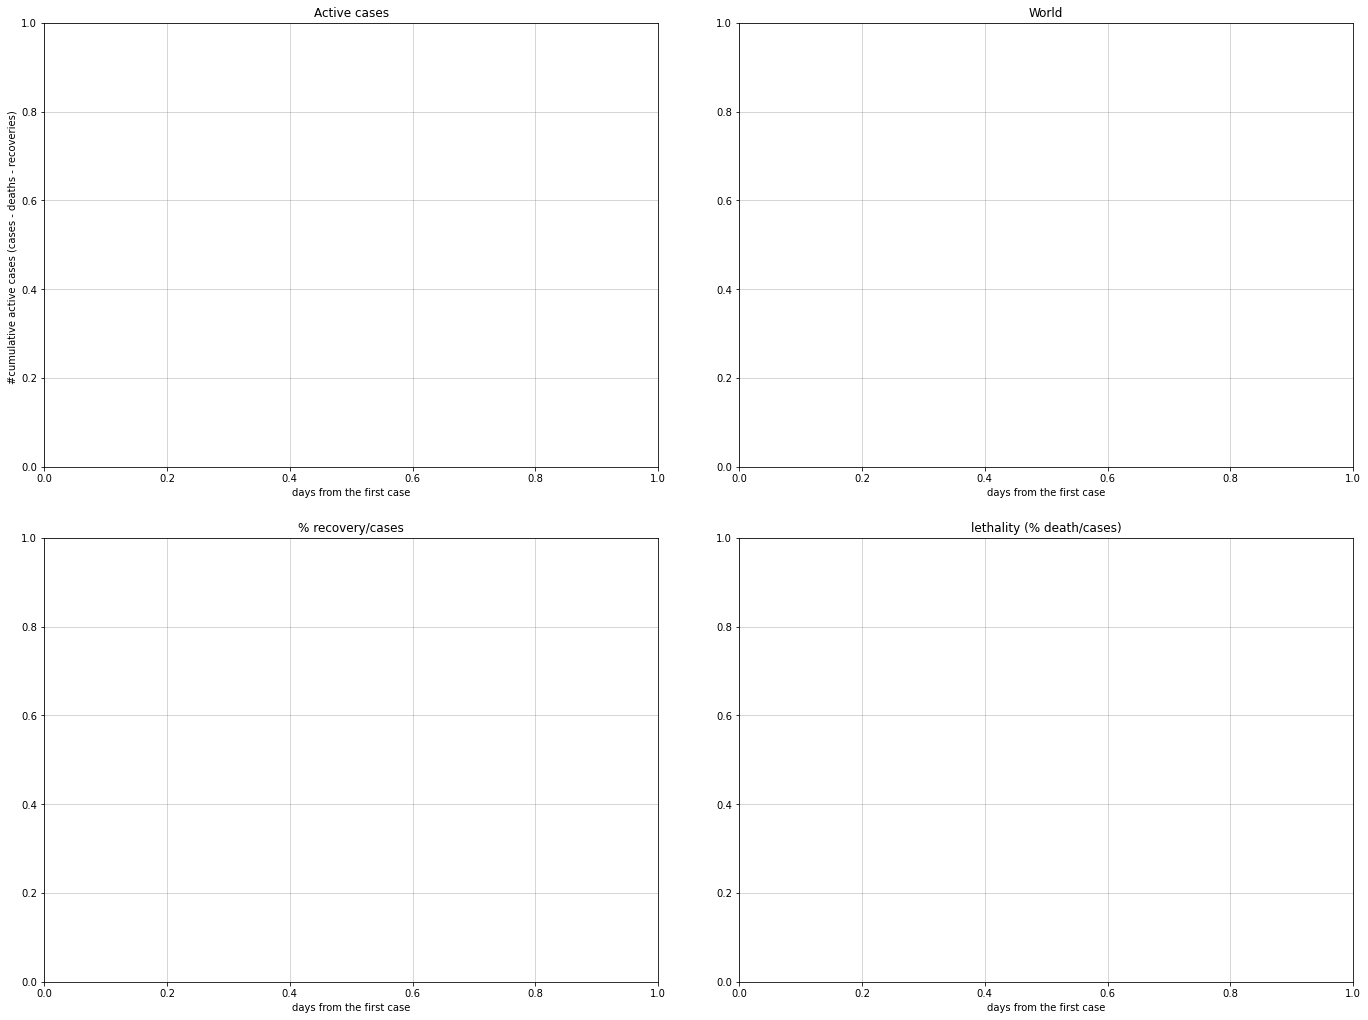

In [381]:
fig, ((ax1, ax2), (ax3, ax4),) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax3.set_title("% recovery/cases")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("lethality (% death/cases)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

ax1.set_title("Active cases")
ax1.set_xlabel("days from the first case")
ax1.set_ylabel("#cumulative active cases (cases - deaths - recoveries) ")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("World")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

for country in monitoredCountries:
    ax3.plot(df[df['country'] == country].day, df[df['country'] == country].perc_recovery, label = country)
    ax4.plot(df[df['country'] == country].day, df[df['country'] == country].perc_death, label = country)
    ax1.plot(df[df['country'] == country].day, df[df['country'] == country].active_cases, label = country)

days = np.arange(1, len(df.groupby('day')['cases'].count())+1,1)
cases_world = df.groupby('day')['case_day'].sum().to_numpy().cumsum()
deaths_world = df.groupby('day')['death_day'].sum().to_numpy().cumsum()
recuperacoes_world = df.groupby('day')['recovery_day'].sum().to_numpy().cumsum()
cases_ativos_world = cases_world - deaths_world - recuperacoes_world

ax2.plot(days, cases_world, label = 'cases')
ax2.plot(days, cases_ativos_world, label = 'active cases')
ax2.plot(days, recuperacoes_world, label = 'recoveries')
ax2.plot(days, deaths_world, label = 'deaths')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/world_active_cases_percentages.png')

### Generating the markdown file

In [12]:
f = open('../analysis/README.md', 'w')

readme = '# **Analysis and monitoring**\n'
readme += 'These analysis are related to the Covid19 pandemic data up to **' + today + '**.\n\n'
readme += 'As there are many countries to have all of their data plotted together, I selected a few of them plus Brazil to be compared with:'
readme += str(monitoredCountries) + '.\n\n'
readme += 'Some countries are not in UN dataset, so we can not analyse them by population. They can be found at the end of the *[data_engineering.ipynb](../data_engineering.ipynb)*.\n'
readme += '\n*Tip: you can set yourself at the analysis notebook which countries you prefer to compare*\n\n'
readme += '## Top 5 deadliest countries + Brazil\n'
readme += df_top_deaths.to_markdown()
# readme += tabulate(df_top_deaths.values,df_top_deaths.columns, tablefmt="pipe")
readme += '\n\n\n ## Top 5 most transmissible countries + Brazil\n'
readme += df_top_cases.to_markdown()
#tabulate(df_top_cases.values,df_top_cases.columns, tablefmt="pipe")

readme += '\n----------------------\n'
readme += '## World\' analysis\n'
readme += '### Cases and deaths\n'
readme += '![](world_cases_deaths.png)'

readme += '\n\n ### Cases and deaths per million\n'
readme += 'Million of population normalizes the features so they can me better comparable among the selected countries. As we can see, the first charts shows us how aggressive the pandemic is in Italy, Spain and somehow in France.\n'
readme += '![](world_cases_deaths_million.png)'

readme += '\n\n ### Active cases, world overview, % recoveries and lethality\n'
readme += '![](world_active_cases_percentages.png)'

readme += '\n----------------------\n'
readme += '## Brazil\'s analysis\n'
readme += '\n\n ### Cases, deaths and recoveries\n'
readme += '![](brazil_number_million_variation.png)'

readme += '\n\n ### Moving averages (last 7 days)\n'
readme += '![](brazil_movingAvg.png)'

f.write(readme)
f.close()
print('Analysis done!')

Analysis done!


KeyError: 'data'